#### Part 1: A discrete-time model

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

from scipy.stats import t
from scipy import stats
np.random.seed(42)


We are following the Markov model in order to model discrete time. Thw model follows women after they had their breast tumor removed. The cancer may reappear close to the removed tumor. The probability of the tumor recurances are following the 5 states:

0: Post-surgery (initial state)

1: Local recurrence

2: Distant metastasis

3: Both local and distant

4: Death (absorbing state — once entered, cannot leave)

We simulate 1000 women each state 0. One step = 1 month. Stop simulation when patient reaches state 4. 


Assume that one time step equals one month. Simulate 1000 women, all
starting in state 1, until death. Summarize the lifetime distribution of the
women, after surgery, for example using a histogram. In what proportion of
women does the cancer eventually reappear, locally?

In [28]:
n = 1000 # no. of women to simulate

# The probability matrix (P)
P = np.array([[0.9915, 0.005, 0.0025, 0, 0.001],
              [0, 0.986, 0.005, 0.004, 0.005],
              [0, 0, 0.992, 0.003, 0.005],
              [0, 0, 0, 0.991, 0.009], 
              [0, 0, 0, 0, 1]])

# Simulation for a single patient
def simulate_patient(P, X0=0): # X0 = 0 - All start in state 0 (Healthy)
    state = X0
    seq_state = [state] # list to record all the states the patient visits during the simulation. patient starts in state so thats added first. New states will be appended to this list — each representing the patient's next health state at the next month.
    while state !=4:
        state = np.random.choice(range(0,5), p=P[state])
        seq_state.append(state)
    return seq_state

test_path = simulate_patient(P)
#print(test_path[0])
#print(test_path[-1])

# Simulate all 1000 patients
all_patient_journey = [] # list of 1000 lists — one per patient

for _ in range(n):
    patient_journey = simulate_patient(P)
    all_patient_journey.append(patient_journey)

lifetimes = []          # no. of transitions until death (in months)
local_recurrences = 0   # counter for how many had local recurrence (state 1)

for journey in all_patient_journey:
    lifetime = len(journey) - 1 # exclude initial state
    lifetimes.append(lifetime)

    if 1 in journey: # Check if patient ever visited state 1 (local recurrence)
        local_recurrences +=1

# Compute the proportion of patients who had local recurrence
proportion_local_recurrence = local_recurrences / n
print(f"The proportion of women with local recurrence is: {proportion_local_recurrence:.4f}")
# variance


The proportion of women with local recurrence is: 0.5890


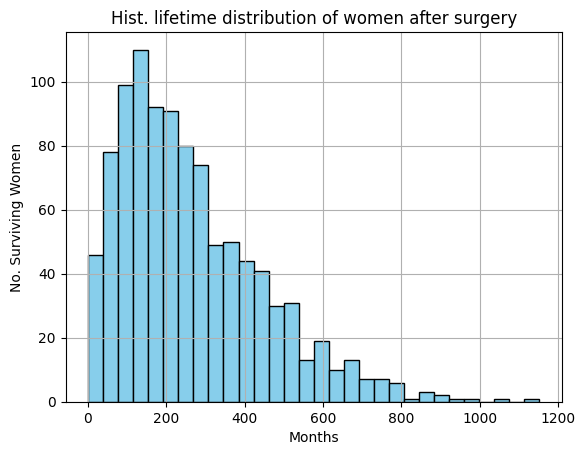

In [29]:
import matplotlib.pyplot as plt

plt.hist(lifetimes, bins=30, color='skyblue', edgecolor='black')
plt.title("Hist. lifetime distribution of women after surgery")
plt.xlabel("Months")
plt.ylabel("No. Surviving Women")
plt.grid(True)
plt.show()

Simulations can be validated by ensuring they are consistent with analytical
results. One way to do this, is to ensure the distribution over the states at a
certain time is consistent with what we expect.

#### Analytical solution

find the empirical distribution of $X_{120}$. This is compared to the theoretical distribution $$ p_{t} = p_{o} * p^{t}$$

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Parameters
n = 1000
t = 120  # Month at which to evaluate distributions

# Transition matrix
P = np.array([
    [0.9915, 0.005, 0.0025, 0.0,    0.001],
    [0.0,    0.986, 0.005,  0.004,  0.005],
    [0.0,    0.0,   0.992,  0.003,  0.005],
    [0.0,    0.0,   0.0,    0.991,  0.009],
    [0.0,    0.0,   0.0,    0.0,    1.0]
])

# Simulation function up to time t
def simulate_patient_fixed_t(P, t=120, X0=0):
    state = X0
    for _ in range(t):
        if state == 4:  # death
            break
        state = np.random.choice(range(5), p=P[state])
    return state

# Simulate final states of all patients at time t
#final_states = [simulate_patient_fixed_t(P, t=t) for _ in range(n)]

final_states = []
for _ in range(n):
    state = simulate_patient_fixed_t(P, t=t) # Simulate one patient up to time t
    final_states.append(state)

# Empirical distribution
counts = Counter(final_states)
empirical_distribution = [counts.get(i, 0) / n for i in range(5)]

# Theoretical distribution using matrix exponentiation
p0 = np.array([1, 0, 0, 0, 0])
Pt = np.linalg.matrix_power(P, t)
theoretical_distribution = np.dot(p0, Pt)


In [31]:
print(f"{'State':<10}{'Empirical':<15}{'Theortical':<15}")
for i in range(5):
    state = f"State {i}"
    emp = round(empirical_distribution[i], 4)
    theo = round(theoretical_distribution[i], 4)
    print(f"{state:<10} {emp:<15} {theo:<15}")


State     Empirical      Theortical     
State 0    0.361           0.359          
State 1    0.163           0.159          
State 2    0.182           0.1661         
State 3    0.055           0.0677         
State 4    0.239           0.2482         


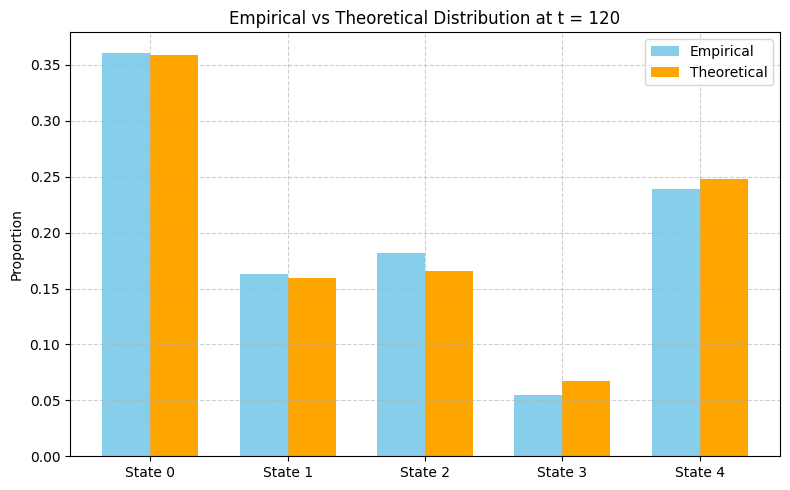

In [32]:

# Plotting
labels = [f"State {i}" for i in range(5)]
x = np.arange(len(labels))

plt.figure(figsize=(8, 5))
bar_width = 0.35
plt.bar(x - bar_width/2, empirical_distribution, bar_width, label="Empirical", color='skyblue')
plt.bar(x + bar_width/2, theoretical_distribution, bar_width, label="Theoretical", color='orange')

plt.xticks(x, labels)
plt.ylabel("Proportion")
plt.title("Empirical vs Theoretical Distribution at t = 120")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

We can use a $\chi^2$-test and obtain a test statistic which can then be compared with a $\chi^2$ distribution with $df = n_{\mathrm{classes}} - 1$ degrees of freedom. 

$$
T = \sum^{n_{\mathrm{classes}}}_{i=1} \frac{ ( n_{\mathrm{observed},i} - n_{\mathrm{expected},i} )^2 }{ n_{\mathrm{expected},i} }
$$

We make the following observations:
- If $\chi^2_{observed}>\chi^2_{critical}$ we can reject the null hypothesis that the two samples come from the same distribution.
- The p-value in the context of a $\chi^2$ test represents the probability of observing a $\chi^2$ statistic as extreme as, or more extreme than, the observed value under the null hypothesis.


In [33]:
from scipy.stats import chi2

#### $\chi^2$-test: Direct method

In [42]:
# Total number of patients
n = 1000

# Observed counts from simulation (empirical)
observed_counts = np.array([count for count in Counter(final_states).values()])
# Ensure the order of states 0–4
observed_counts = np.array([Counter(final_states).get(i, 0) for i in range(5)])

# Expected counts from theoretical distribution
expected_counts = n * theoretical_distribution

# Compute test statistic
T = np.sum((observed_counts - expected_counts)**2 / expected_counts)
print("The observed test statistic is:", round(T, 4))

# Degrees of freedom
df = len(expected_counts) - 1  # no estimated parameters, so m = 0
alpha = 0.05

# Critical value
critical_value = chi2.ppf(1 - alpha, df)
print("The critical value is:", round(critical_value, 4))

# p-value
p_value = chi2.sf(T, df)
print("The p-value is:", round(p_value, 4))

# Interpretation
if p_value > alpha:
    print("✅ The distributions are not significantly different (fail to reject H0).")
else:
    print("❌ The distributions are significantly different (reject H0).")

# Degrees of freedom
df = len(expected_counts) - 1

# Significance level
alpha = 0.05

# Calculate critical value
chi_squared = chi2.ppf(1 - alpha, df)
print("The critical value is:", chi_squared)

# Calculate the p-value under the observed test statistic
p_value = chi2.sf(T, df)
print("The p-value is:", p_value)

The observed test statistic is: 4.3752
The critical value is: 9.4877
The p-value is: 0.3576
✅ The distributions are not significantly different (fail to reject H0).
The critical value is: 9.487729036781154
The p-value is: 0.35760540319084044


We fail to reject the null hypothesis $H_{0}=0$ (i.e., there is no significant difference between distributions) as $\chi^2_{observed}<\chi^2_{critical}$. This result is also supported by the high p-value (𝑝=0.7476), indicating strong agreement between the empirical and theoretical distributions.

#### Task 3: In your simulations, what is the distribution over the states at t = 120? Does this correspond to what we expect? Answer the question using an appropriate statistical test.

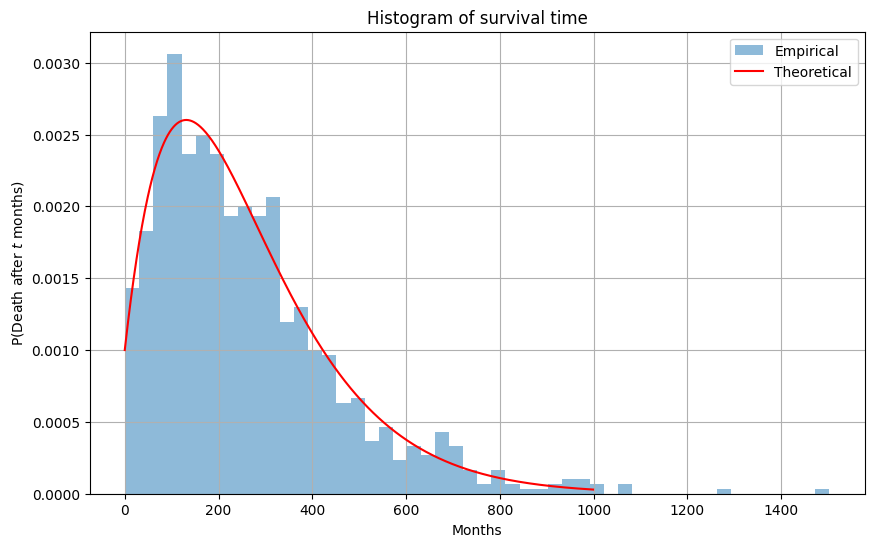

In [35]:
# simulated lifetimes
simulated_lifetimes = [] #  number of months each simulated woman lived before reaching the absorbing state (death)
for _ in range(n):
    state = 0
    t = 0
    while state != 4:  # state 5 is index 4 in 0-based Python
        state = np.random.choice(range(5), p=P[state])
        t += 1
    simulated_lifetimes.append(t)


# Create Ps (transient states) and ps (absorbing column)
Ps = P[:4, :4]       # Remove last row and column → 4x4 transient matrix
ps = P[:4, 4]        # column vector indicating the probability of dying from states 1-4

# Initial distribution (everyone starts in state 1)
pi_0 = np.array([1, 0, 0, 0])

# Compute P(T=t) for t in [0, max_time]
max_time = 1000
probs = []

Pt = np.identity(4)  # Start with Ps^0 = I

for t in range(max_time):
    prob_t = pi_0 @ Pt @ ps
    probs.append(prob_t)
    Pt = Pt @ Ps  # Update Ps^t

# Plot "Histogram of the probability of dying after t months, overlaid with the theoretical P(T = t)"
plt.figure(figsize=(10, 6))
plt.hist(simulated_lifetimes, bins=50, density=True, alpha=0.5, label="Empirical")
plt.plot(range(max_time), probs, 'r-', label="Theoretical")
plt.xlabel("Months")
plt.ylabel("P(Death after $t$ months)")
plt.title("Histogram of survival time")
plt.legend()
plt.grid(True)
plt.show()


### 🧮 Theoretical Lifetime Distribution

To validate the simulation, we compare the **empirical lifetime distribution** with the **theoretical phase‑type distribution**, which models the time until absorption in a Markov chain with one absorbing state (death).

#### 📘 Probability Mass Function (PMF)

The probability that a person dies exactly at time \( t \) is given by:

$$
P(T = t) = \boldsymbol{\pi} \cdot \mathbf{P}_s^{\,t} \cdot \mathbf{p}_s
$$

- $ \boldsymbol{\pi} = [1, 0, 0, 0] $ (initial distribution)  
- $ \mathbf{P}_s $ is the $ 4 \times 4 $ transition sub‑matrix of transient states  
- $ \mathbf{p}_s $ is the column vector of transition probabilities to the absorbing state

#### 📈 Cumulative Distribution Function (CDF)

The cumulative probability of dying by time \( t \) is:

$$
P(T \le t) = \sum_{k=0}^{t} P(T = k)
$$

This theoretical CDF can be plotted and compared to the empirical CDF from the simulation.

### 📏 Expected Lifetime

The expected time until death (absorption) is:

$$
\mathbb{E}[T] = \boldsymbol{\pi} \cdot (\mathbf{I} - \mathbf{P}_s)^{-1} \cdot \mathbf{1}
$$

- $ \mathbf{I} $ is the identity matrix  
- $ (\mathbf{I} - \mathbf{P}_s)^{-1} $ is the **fundamental matrix**  
- $ \mathbf{1} $ is a column vector of ones

### ✅ Interpretation

- The **PMF** gives the likelihood of dying exactly at month \( t \).  
- The **CDF** shows the probability of having died by time \( t \).  
- $ \mathbb{E}[T] $ is the **average survival time** in months.


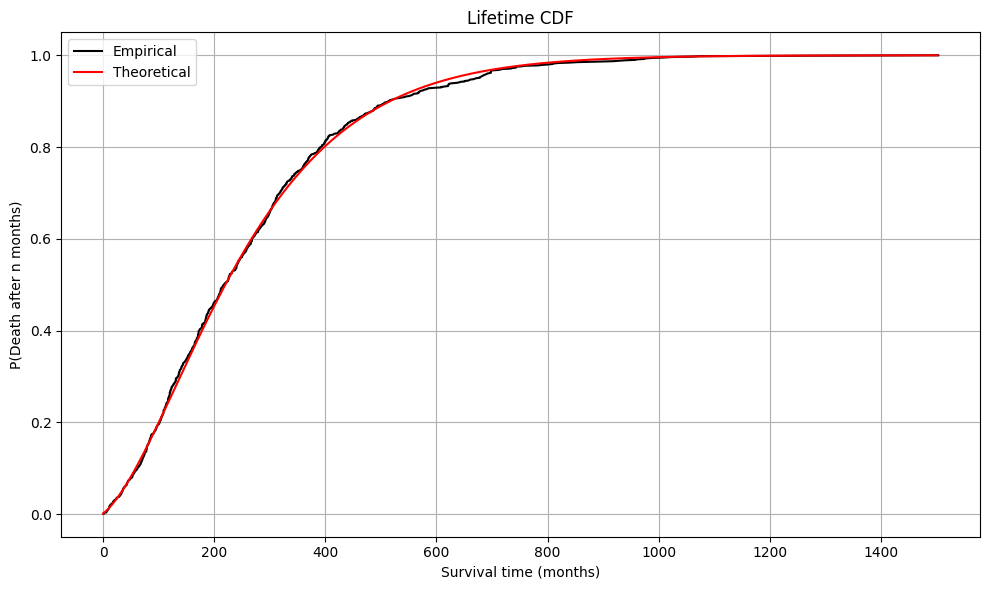

In [36]:
# Sort and compute empirical CDF
sorted_lifetimes = np.sort(simulated_lifetimes)
empirical_cdf = np.arange(1, len(sorted_lifetimes)+1) / len(sorted_lifetimes)

# Compute theoretical CDF
max_time = max(sorted_lifetimes)
Pt = np.identity(4)
cdf_theoretical = []

cum_prob = 0.0
for t in range(max_time):
    prob_t = pi_0 @ Pt @ ps
    cum_prob += prob_t
    cdf_theoretical.append(cum_prob)
    Pt = Pt @ Ps

# Plot both
plt.figure(figsize=(10, 6))
plt.plot(sorted_lifetimes, empirical_cdf, label="Empirical", color='black')
plt.plot(range(max_time), cdf_theoretical, label="Theoretical", color='red')
plt.xlabel("Survival time (months)")
plt.ylabel("P(Death after n months)")
plt.title("Lifetime CDF")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The red line represents the theoretical CDF of the lifetime distribution, while the black line represents the empirical CDF based on the simulated survival times. The close match between the two curves confirms that the simulated survival times follow the theoretical distribution, thereby validating the correctness of the simulation.

#### Kolmogorov-Smirnov test

#### Task 4: Rejection Sampling
Estimate the expected lifetime of a woman who satisfies both of these conditions, survine the 12 months after surgery, During those 12 months, breast cancer reappears, either locally (enters state 2), or distantly (enters state 3), or both (enters state 4).

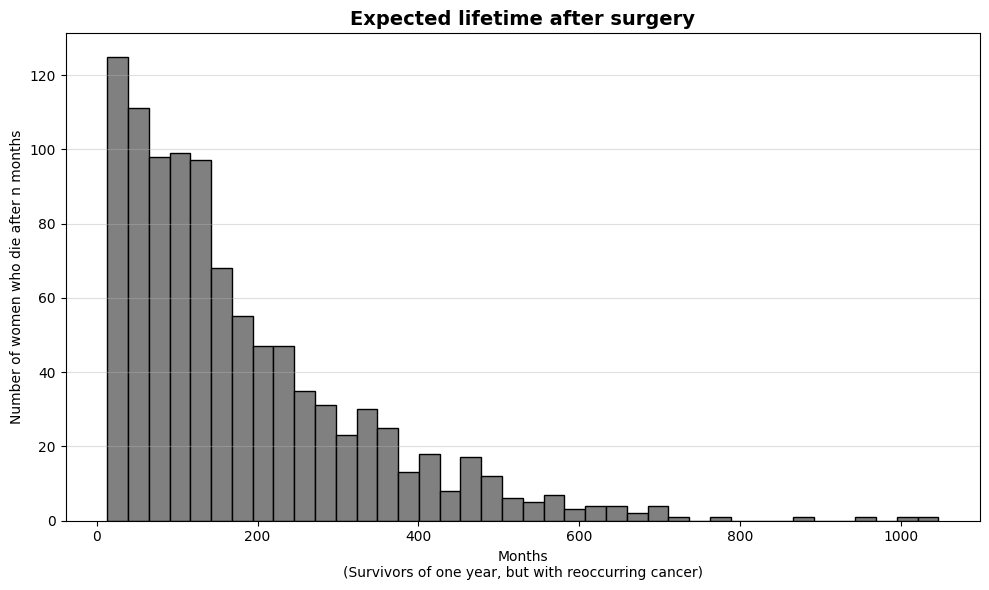

Expected lifetime (given condition): 180.06 months
Caption: Histogram of survival times for women who survived 12 months but had recurrence within the first year


In [37]:
# Rejection sampling
valid_lifetimes = []
n_required = 1000
np.random.seed(42)

while len(valid_lifetimes) < n_required:
    state = 0  # Start at state 1 (index 0)
    t = 0
    visited_recurrence = False
    survived_12_months = False

    while state != 4:  
        if t == 12:
            survived_12_months = True
        if t < 12 and state in [1, 2, 3]:  # check for recurrence in states 2,3,4 (index 1,2,3)
            visited_recurrence = True
        state = np.random.choice(range(5), p=P[state])
        t += 1

    if survived_12_months and visited_recurrence:
        valid_lifetimes.append(t)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_lifetimes, bins=40, color='gray', edgecolor='black')
plt.title("Expected lifetime after surgery", fontsize=14, weight='bold')
plt.xlabel("Months\n(Survivors of one year, but with reoccurring cancer)")
plt.ylabel("Number of women who die after n months")
plt.grid(True, axis='y', alpha=0.4)
plt.tight_layout()
plt.show()

# Compute expected value
expected_lifetime = np.mean(valid_lifetimes)
print(f"Expected lifetime (given condition): {expected_lifetime:.2f} months")
print(f"Caption: Histogram of survival times for women who survived 12 months but had recurrence within the first year")


The histogram shows the survival time distribution of those 1000 women who met the criteria. We observe a rapid drop-off in the number of survivors beyond 100–300 months, with a **conditional expected lifetime of approximately 180.06 months** (~15 years). This indicates that **recurrence within the first year significantly reduces expected survival time**.

In [44]:
# Not required but can be used

import scipy.stats as stats

# Convert to array
lifetimes = np.array(valid_lifetimes)
mean = lifetimes.mean()
std = lifetimes.std(ddof=1)  # sample standard deviation
n = len(lifetimes)

# 95% confidence interval using t-distribution
alpha = 0.05
t_critical = stats.t.ppf(1 - alpha/2, df=n-1)
margin = t_critical * (std / np.sqrt(n))
ci_lower = mean - margin
ci_upper = mean + margin

print(f"Mean: {mean:.3f} months")
print(f"Variance: {np.var(lifetimes, ddof=1):.2f}")
print(f"95% CI: ({ci_lower:.3f}, {ci_upper:.3f}) months")


Mean: 180.056 months
Variance: 23371.74
95% CI: (170.569, 189.543) months


#### Task 5
What fraction of women die within the first 350 months? Answer this by
simulating 200 women, and record the fraction. Do this 100 times. Use con-
trol variates to reduce the variance.
How large a reduction in variance do you see, using control variates, as op-
posed to the crude Monte Carlo estimator?
Hint: Use the mean lifetime after surgery of the 200 simulations as the
control variate.

In [49]:
import numpy as np
from scipy.stats import t

# Settings
n_simulations = 100
n_women = 200
threshold = 350  # months
expected_lifetime = 262.37  # known from earlier derivation

# Define capped simulation function
def simulate_lifetime(P, max_months=2000):
    state = 0
    t = 0
    while state != 4 and t < max_months:
        state = np.random.choice(range(5), p=P[state])
        t += 1
    return t

# Collect batches
Y = []  # fraction who died ≤ 350 months
X = []  # mean lifetimes

np.random.seed(42)

for _ in range(n_simulations):
    lifetimes = [simulate_lifetime(P) for _ in range(n_women)]
    lifetimes = np.array(lifetimes)
    Y.append(np.mean(lifetimes <= threshold))
    X.append(np.mean(lifetimes))

Y = np.array(Y)
X = np.array(X)

# Control variate adjustment
cov_YX = np.cov(Y, X, ddof=1)[0, 1]
var_X = np.var(X, ddof=1)
c = cov_YX / var_X
Y_star = Y - c * (X - expected_lifetime)

# Crude vs CV stats
mean_Y = np.mean(Y)
var_Y = np.var(Y, ddof=1)
mean_Y_star = np.mean(Y_star)
var_Y_star = np.var(Y_star, ddof=1)

# 95% confidence intervals
df = n_simulations - 1
t_crit = t.ppf(1 - 0.05 / 2, df)
ci_Y = (mean_Y - t_crit * np.sqrt(var_Y / n_simulations),
        mean_Y + t_crit * np.sqrt(var_Y / n_simulations))
ci_Y_star = (mean_Y_star - t_crit * np.sqrt(var_Y_star / n_simulations),
             mean_Y_star + t_crit * np.sqrt(var_Y_star / n_simulations))

variance_reduction = (var_Y - var_Y_star) / var_Y * 100

print(f"{'Method':<25}{'Estimate':<10}{'Variance':<10}{'95% CI'}")
print(f"{'-'*55}")
print(f"{'Crude Estimator':<25}{mean_Y:.3f}{var_Y:.4f}   ({ci_Y[0]:.3f}, {ci_Y[1]:.3f})")
print(f"{'Control Variates Estimator':<25}{mean_Y_star:.3f}{var_Y_star:.4f}   ({ci_Y_star[0]:.3f}, {ci_Y_star[1]:.3f})")
print(f"\nVariance reduction: {variance_reduction:.1f}%")


Method                   Estimate  Variance  95% CI
-------------------------------------------------------
Crude Estimator          0.7380.0013   (0.730, 0.745)
Control Variates Estimator0.7370.0003   (0.734, 0.741)

Variance reduction: 76.2%
